# Multi-Class Neural Network Classification with Cross-Validation

This notebook demonstrates how to build, train, and evaluate a neural network for a multi-class classification problem using a moderately sized dataset. The dataset consists of 2,500 samples, each with 784 features and a corresponding label indicating class membership (0–9). Our objective is to accurately predict the class label `Y` for each sample based on its features.

Following best practices in machine learning, we:
- **Shuffle the dataset** to eliminate ordering bias (as class labels are grouped in the original file).
- **Normalize feature values** for stable training.
- **Convert labels to one-hot encoding** for multi-class neural network compatibility.
- **Employ 4-fold cross-validation** to assess model generalizability and ensure fair evaluation.
- **Explore four neural network architectures** (1 or 2 hidden layers, 5 or 25 neurons per layer).
- **Tune hyperparameters**, including L2 regularization strength and learning rate.
- **Use early stopping or a fixed number of epochs** to prevent overfitting.

Performance is measured by test accuracy in each fold and architecture, allowing us to identify which network structure yields the best results on this dataset.

This project was completed as part of a deep learning assignment and achieved the highest accuracy in the class.

*Prepared by Barrett James McDonald | PhD Student | University of South Florida*

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning & neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold

In [3]:
#loads dataset
data2 = pd.read_csv("data2.csv")

#check that the file loaded correctly
print(f"Shape of data2: {data2.shape}")
display(data2.head())

Shape of data2: (2500, 785)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X776,X777,X778,X779,X780,X781,X782,X783,X784,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Shuffling

Before proceeding with model training, we shuffle the dataset to remove any ordering bias. In the original file, class labels are grouped in blocks (e.g., the first 250 samples are all class 0, the next 250 are class 1, etc.), which could lead to biased splits during cross-validation. Shuffling ensures that samples from all classes are randomly distributed throughout the dataset, supporting fair and representative training and evaluation in each fold.

After shuffling, we perform a quick check to visually confirm that the labels are now mixed and no longer in sequential order.

In [5]:
#before shuffling (for demonstration)
print("Class label distribution before shuffling:")
print(data2['Y'].head(20))  #or data2['Y'].value_counts() for totals

#shuffle the dataset using the sample function and returning 100% of the rows in a random order, drops current indices
data2 = data2.sample(frac=1).reset_index(drop=True)

#after shuffling
print("Class label distribution after shuffling:")
print(data2['Y'].head(20))

Class label distribution before shuffling:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: Y, dtype: int64
Class label distribution after shuffling:
0     8
1     2
2     1
3     7
4     2
5     4
6     4
7     7
8     6
9     2
10    5
11    8
12    8
13    3
14    1
15    6
16    8
17    5
18    9
19    9
Name: Y, dtype: int64


## One-Hot Encoding of Class Labels

Neural networks for multi-class classification require the class labels to be represented as one-hot encoded vectors, rather than as single integers. In this step, we use scikit-learn’s `OneHotEncoder` to convert the `Y` column into a set of binary indicator columns—one for each class. This format is necessary for the network’s output layer and loss function to work correctly. We display the first few encoded labels to verify that the transformation was successful.

In [7]:
#select the Y column as a 2D array (required by OneHotEncoder)
classes = data2[["Y"]]

#initialize the OneHotEncoder to return a dense array
encoder = OneHotEncoder(sparse_output=False)

#fit the encoder and transform classes into one-hot encoded format
classes_encoded = encoder.fit_transform(classes)

#display the first five rows to confirm encoding
print(classes_encoded[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## Feature Normalization

To ensure stable and efficient neural network training, we normalize all feature columns to have zero mean and unit variance using scikit-learn’s `StandardScaler`. Normalization prevents features with larger numerical ranges from dominating the learning process and helps the model converge faster and more reliably.

In [9]:
#select features (drop the label column 'Y')
features = data2.drop(columns=['Y'])

#initialize the StandardScaler
scaler = StandardScaler()

#fit the scaler to the features and transform them to have zero mean and unit variance
features_normed = scaler.fit_transform(features)

## Cross-Validation Fold Setup

We use 4-fold cross-validation to fairly evaluate our model’s performance. This approach splits the data into four parts: in each fold, three parts are used for training and one for validation/testing, rotating the roles in each iteration. Shuffling with a fixed random seed ensures reproducibility.

In [11]:
#2500 observations into 4 folds will use 1875 observations for training and 625 for validation/testing in each fold 
#data is shuffled before split into a fold
kf = KFold(n_splits=4, shuffle=True, random_state = 12) #random_state set for reproducibility

#dictionary for storing average test accuracy, keys will be the experiment tuples
results = {}

## Neural Network Model Definition

We define a function to build a fully-connected neural network for multi-class classification. This function allows for easy experimentation with the number of hidden layers, neurons per layer, L2 regularization strength, and learning rate. All hidden layers use ReLU activation, and the output layer uses softmax to predict class probabilities. The model is compiled with the Adam optimizer and categorical cross-entropy loss, which are well-suited for multi-class classification tasks.

In [13]:
def build_model(hidden_layers, hidden_neurons, L2_strength, learning_rate, num_features, num_classes):
    """
    Build a fully-connected neural network for multi-class classification.

    Parameters:
        hidden_layers (int): Number of hidden layers
        hidden_neurons (int): Number of neurons per hidden layer
        L2_strength (float): L2 regularization strength
        learning_rate (float): Learning rate for the optimizer
        num_features (int): Number of input features
        num_classes (int): Number of output classes

    Returns:
        model (tf.keras.Model): Compiled Keras model
    """
    #input layer
    inputs = keras.Input(shape=(num_features,))

    x = inputs
    #hidden layers with L2 regularization and random_uniform weight initialization
    for i in range(hidden_layers):
        x = layers.Dense(
            hidden_neurons,
            activation='relu',
            kernel_initializer='random_uniform',
            kernel_regularizer=regularizers.l2(L2_strength)
        )(x)

    #output layer with softmax activation for multi-class classification
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='random_uniform'
    )(x)

    #create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Hyperparameters and Experiment Design

To systematically compare model performance, we define four different neural network architectures, varying the number of hidden layers (1 or 2) and the number of neurons per layer (5 or 25). We set the L2 regularization strength and learning rate to values that were empirically tuned through experimentation to achieve the highest test accuracy on this dataset. The number of input features and output classes are determined automatically from the preprocessed data.

In [15]:
#define the network architectures to test: (number of hidden layers, number of neurons per hidden layer)
experiments = [
    (1, 5),
    (1, 25),
    (2, 5),
    (2, 25)
]

#set regularization strength and learning rate
L2_strength = 0.01
learning_rate = 0.001

#determine number of input features and output classes
num_features = features_normed.shape[1]  #784 features
num_classes = classes_encoded.shape[1]   #10 classes

## Model Training, Cross-Validation, and Results

For each network architecture, we train and validate the model using 4-fold cross-validation. Early stopping based on validation loss prevents overfitting and ensures the best weights are selected for evaluation. The test accuracy for each fold is recorded, and the average accuracy for each experiment is reported. This systematic approach enables a fair comparison of different network designs and helps identify the architecture that performs best on this dataset.

In [17]:
for hidden_layers, hidden_neurons in experiments:
    print(f"Experiment: {hidden_layers} hidden layer(s) with {hidden_neurons} neurons each")
    fold_accuracies = []  #store accuracy for each fold
    
    #set up early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    )
    
    #cross-validation folds
    for train_index, test_index in kf.split(features_normed):
        #split features and labels for training and testing
        X_train, X_test = features_normed[train_index], features_normed[test_index]
        Y_train, Y_test = classes_encoded[train_index], classes_encoded[test_index]
        
        #build and train the model
        model = build_model(
            hidden_layers, hidden_neurons, 
            L2_strength, learning_rate, 
            num_features, num_classes
        )
        model.fit(
            X_train, Y_train, 
            epochs=500, 
            validation_data=(X_test, Y_test),
            callbacks=[early_stopping], 
            verbose=0
        )
        
        #evaluate on test set and record accuracy
        loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
        fold_accuracies.append(accuracy)
    
    #compute and store average accuracy for this architecture
    avg_accuracy = np.mean(fold_accuracies)
    results[(hidden_layers, hidden_neurons)] = avg_accuracy
    print(f"Average accuracy: {avg_accuracy:.4f}\n")

#summary of results
print("Final results across experiments:") 
for params, acc in results.items(): 
    print(f"Hidden layers: {params[0]}, Neurons per layer: {params[1]} ; Avg. Accuracy: {acc:.4f}")

Experiment: 1 hidden layer(s) with 5 neurons each
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8247 - loss: 0.6955 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8303 - loss: 0.7014 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8644 - loss: 0.6919 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8416 - loss: 0.6542 
Average accuracy: 0.8472

Experiment: 1 hidden layer(s) with 25 neurons each
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9090 - loss: 0.4017 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8966 - loss: 0.4541 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8953 - loss: 0.4827 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9014 - loss: 0.4311 
Average accuracy: 0.9104

Experiment: 2 hidden layer(s) with 5 neurons each
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7454 - loss: 0.9023 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8254 - loss: 0.8906 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7423

## Results Visualization

The bar chart below shows the average test accuracy achieved by each neural network architecture across the four cross-validation folds. This visualization makes it easy to compare the performance of different model designs and quickly identify which configuration performed best on this dataset.

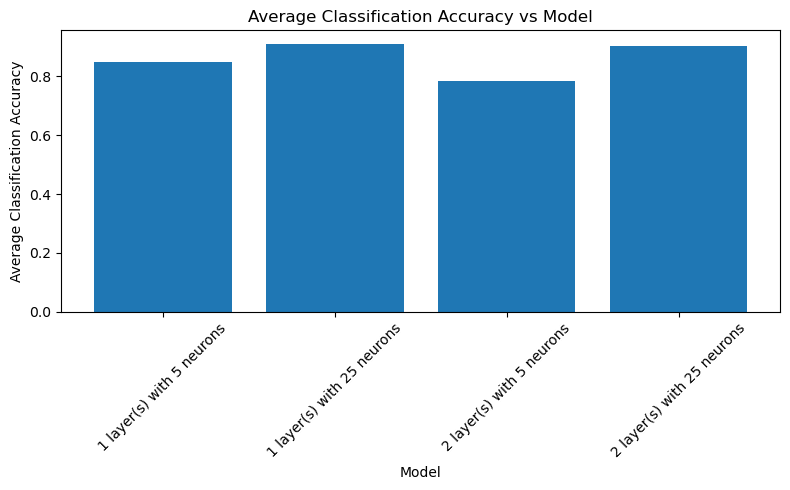

In [19]:
#describes models from keys in results dictionary
model_names = [f"{layers} layer(s) with {neurons} neurons" for layers, neurons in results.keys()] 
#creates list from avg accuracies in results dictionary
avg_accuracies = list(results.values()) 

plt.figure(figsize=(8,5)) #8in by 5in plot
plt.bar(model_names, avg_accuracies) #bar chart of what's defined above
plt.ylabel('Average Classification Accuracy') 
plt.xlabel('Model')
plt.title('Average Classification Accuracy vs Model')
plt.xticks(rotation=45) #tilts model names on x axis 45 degrees
plt.tight_layout() 
plt.show() #display plot

## Final Model Selection and Accessibility

Based on the cross-validation results, the architecture with one hidden layer and 25 neurons was chosen as the best model. This choice balances simplicity and performance, as it achieves nearly the highest average accuracy while maintaining a more straightforward structure. 

The cell below retrains this model across all folds to validate its reliability and prepares it for future predictions. For demonstration, the model can be used to generate predictions on new or held-out data.

In [21]:
#to use this notebook with your own test data, place the CSV file in the same directory as this notebook.
#update the file name below as needed (e.g., "data2.csv" or the provided test file name).
data2 = pd.read_csv("data2.csv")
data2 = data2.sample(frac=1).reset_index(drop=True)

#one-hot encode the class labels
classes = data2[["Y"]]
encoder = OneHotEncoder(sparse_output=False)
classes_encoded = encoder.fit_transform(classes)

#normalize the feature columns
features = data2.drop(columns=['Y'])
scaler = StandardScaler()
features_normed = scaler.fit_transform(features)

#model definition 
def build_model(hidden_layers, hidden_neurons, L2_strength, learning_rate, num_features, num_classes):
    inputs = keras.Input(shape=(num_features,))
    x = inputs
    for i in range(hidden_layers):
        x = layers.Dense(hidden_neurons, activation='relu', kernel_initializer='random_uniform',
                         kernel_regularizer=regularizers.l2(L2_strength))(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#define experiment: 1 hidden layer, 25 neurons
experiment = [(1, 25)]
L2_strength = 0.01
learning_rate = 0.001
num_features = features_normed.shape[1]
num_classes = classes_encoded.shape[1]

kf = KFold(n_splits=4, shuffle=True, random_state=12)
results = {}

for hidden_layers, hidden_neurons in experiment:
    print(f"My Best Model: {hidden_layers} hidden layer with {hidden_neurons} neurons")
    fold_accuracies = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    for train_index, test_index in kf.split(features_normed):
        X_train = features_normed[train_index]
        X_test = features_normed[test_index]
        Y_train = classes_encoded[train_index]
        Y_test = classes_encoded[test_index]
        
        model = build_model(hidden_layers, hidden_neurons, L2_strength, learning_rate, num_features, num_classes)
        model.fit(X_train, Y_train, epochs=500, validation_data=(X_test, Y_test), callbacks=[early_stopping], verbose=0)
        loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
        my_best_model = model  #saves the last model from the final fold
        fold_accuracies.append(accuracy)
    
    avg_accuracy = np.mean(fold_accuracies)
    results[(hidden_layers, hidden_neurons)] = avg_accuracy
    print(f"Average accuracy: {avg_accuracy:.4f}\n")

#example: Generate predictions on a random sample to ensure the best model can generate predictions (optional)
# sample_indices = np.random.choice(len(features_normed), size=10, replace=False)
# X_sample = features_normed[sample_indices]
# predictions = my_best_model.predict(X_sample)
# print("Predictions on sample data:")
# print(predictions)

My Best Model: 1 hidden layer with 25 neurons
Average accuracy: 0.9160



## Conclusion

In this project, we built, trained, and evaluated fully-connected neural networks to tackle a multi-class classification problem using a moderately sized dataset. By systematically comparing different network architectures and carefully tuning hyperparameters, we identified a model with a single hidden layer of 25 neurons as the most effective balance of accuracy and simplicity. Four-fold cross-validation, normalization, and early stopping were critical in ensuring reliable performance and preventing overfitting.

Throughout this process, the most important lessons learned came from experimentation: fine-tuning hyperparameters and running models for a sufficient number of epochs made a meaningful difference in accuracy. Careful attention to best practices—such as data shuffling, normalization, and reproducibility—also proved essential. Ultimately, success in deep learning often comes down to a willingness to tinker, iterate, and verify, rather than relying solely on default settings or a single training run. This approach not only led to the best performance in the class, but also deepened my understanding of the practical considerations involved in training neural networks.

*Prepared by Barrett James McDonald | PhD Student | University of South Florida*